<a href="https://colab.research.google.com/github/JonathanLehner/Colab-collection/blob/master/Mask_RCNN_counting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mask R-CNN Demo

This is a [Mask R-CNN](https://arxiv.org/abs/1703.06870) colab notebook using the open source project [matterport/Mask_RCNN](https://github.com/matterport/Mask_RCNN).

Follow this to make your picam stream:
https://docs.dataplicity.com/docs/stream-live-video-from-your-pi

Our pi is at 
https://coverless-gnu-0291.dataplicity.io/?action=stream

In [0]:
# define variables
import os
repository_url = 'https://github.com/JonathanLehner/Colab-collection'
repository_name = os.path.basename(repository_url)
loader_path = './products.py'

products_model = 'https://github.com/JonathanLehner/Colab-collection/releases/download/0.1/mask_rcnn_products_0060_new.h5'
products_model_name = os.path.basename(products_model)
products_data_url = 'https://github.com/JonathanLehner/Colab-collection/releases/download/0.1/labeled_training_images3.0.zip'
products_filename = os.path.basename(products_data_url)
products_filename_wo_ext = 'labeled_training_images'

server_address = 'www.grabigo.com'
pi_address = 'https://coverless-gnu-0291.dataplicity.io/?action=stream'
test_category = "/test_do_not_label"

# Products class names
# Index of the class in the list is its ID. For example, to get ID of
# the huerlimann class, use: class_names.index('huerlimann')
class_names = ['BG', "apple", "banana", "feldschloesschen", "huerlimann", "ramen", "redbull", "tuc", "tuna", "x", "y", "z"]

mode = "counting"


## Notebook Preferences

In [0]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [0]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Installation

In [0]:
# install Mask RCNN
import os
from os.path import exists, join, basename

project_name = "Mask_RCNN"
if not exists(project_name):
  # clone and install
  !git clone -q https://github.com/matterport/Mask_RCNN.git
  !cd $project_name && pip install -q -r requirements.txt
  
import sys
sys.path.append(project_name)

## Download and prepare our model

Following code is copied from https://github.com/matterport/Mask_RCNN/blob/master/samples/demo.ipynb and updated for the Colab.

In [0]:
%cd /content/Mask_RCNN/
os.system('rm {0}'.format(products_model_name))
os.system('wget {0}'.format(products_model))
%cd /content/

/content/Mask_RCNN
/content


In [7]:
import random
import math
import time
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False

# Root directory of the project
ROOT_DIR = os.path.abspath("/content/Mask_RCNN/")
print(ROOT_DIR)

# Root directory of the project
ROOT_DIR = os.path.abspath("/content/Mask_RCNN/")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

/content/Mask_RCNN


## Configurations

In [8]:
# load the training script
%cd /content/Mask_RCNN/samples/
os.system('rm -r {0}'.format(repository_name))

print('git clone {0}'.format(repository_url))
os.system('git clone {0}'.format(repository_url))

/content/Mask_RCNN/samples
git clone https://github.com/JonathanLehner/Colab-collection


0

In [9]:
%cd /content/Mask_RCNN/samples/Colab-collection
products = __import__("products")
%cd /content/Mask_RCNN/

config = products.ProductConfig()

/content/Mask_RCNN/samples/Colab-collection
/content/Mask_RCNN


In [10]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                21
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [11]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Set path to products weights file

# Download file from the Releases page and set its path
# https://github.com/matterport/Mask_RCNN/releases
weights_path = '/content/Mask_RCNN/{0}'.format(products_model_name)

# Or, load the last model you trained
# weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Loading weights  /content/Mask_RCNN/mask_rcnn_products_0060_new.h5


## Execute on a test image

First, download a test image from the internet:

--2019-05-07 20:11:27--  https://www.beerworld.ch/upload/5544.jpg
Resolving www.beerworld.ch (www.beerworld.ch)... 91.206.161.150
Connecting to www.beerworld.ch (www.beerworld.ch)|91.206.161.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28027 (27K) [image/jpeg]
Saving to: ‘5544.jpg.3’

5544.jpg.3          100%[===================>]  27.37K  --.-KB/s    in 0s      

2019-05-07 20:11:28 (321 MB/s) - ‘5544.jpg.3’ saved [28027/28027]



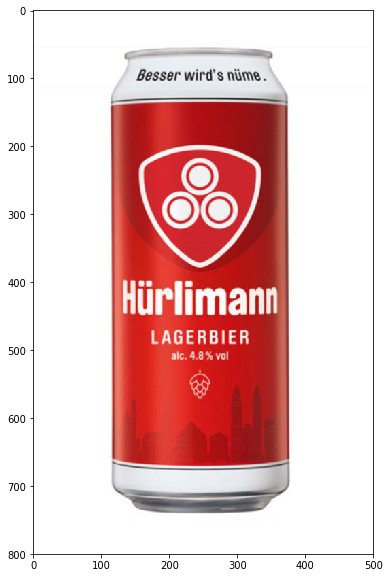

In [12]:
!wget https://www.beerworld.ch/upload/5544.jpg #image of a single huerlimann can
image = skimage.io.imread('/content/5544.jpg')
plt.figure(figsize=(15, 10))
plt.imshow(image)

Now test Mask RCNN on the downloaded image:

Processing 1 images
image                    shape: (800, 500, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 21)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
executed in 8.641s
['BG', 'apple', 'banana', 'feldschloesschen', 'huerlimann', 'ramen', 'redbull', 'tuc', 'tuna']


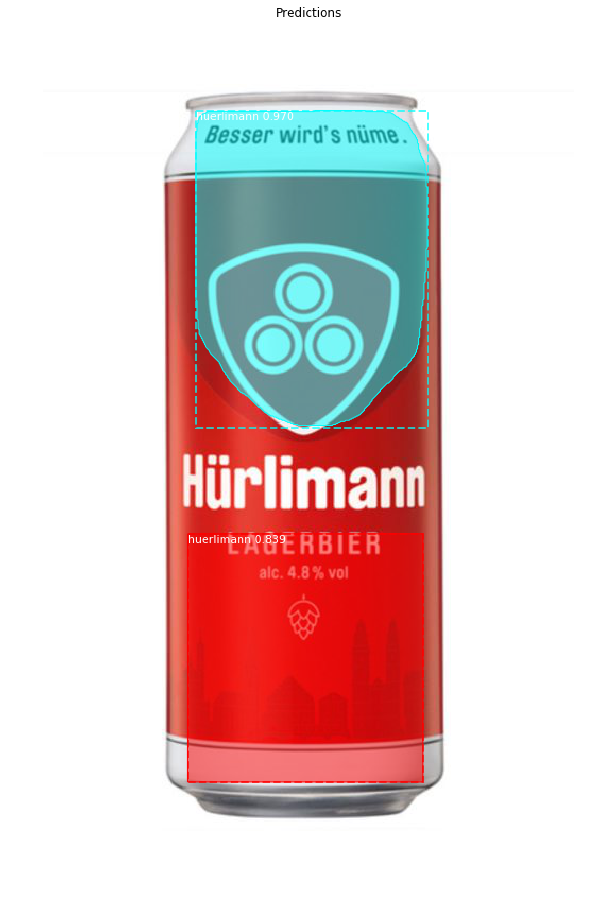

In [13]:
t = time.time()
# Run detection
results = model.detect([image], verbose=1)
print("executed in %.3fs" % (time.time() - t))
#print(results)

classes = ['BG', 'apple', 'banana', 'feldschloesschen', 'huerlimann', 'ramen', 'redbull', 'tuc', 'tuna']

# Visualize results
ax = get_ax(1)
r = results[0]
print(classes)
visualize.display_instances(image, 
                            r['rois'], 
                            r['masks'],
                            r['class_ids'], 
                            classes, 
                            r['scores'],
                            ax=ax,
                            title="Predictions"
                            )

In [14]:
print(r['class_ids'])
print(class_names)

import collections
class_ids = r['class_ids']
counter=collections.Counter(class_ids)
print(counter)

for key in counter:
    print("Object: {}, Quantity: {}".format(class_names[key], counter[key]))


[4 4]
['BG', 'apple', 'banana', 'feldschloesschen', 'huerlimann', 'ramen', 'redbull', 'tuc', 'tuna', 'x', 'y', 'z']
Counter({4: 2})
Object: huerlimann, Quantity: 2


In [15]:
# Connect to the server
!pip install python-meteor
from MeteorClient import MeteorClient
client = MeteorClient('wss://{0}/websocket'.format(server_address))
client.connect()
print('connected')

connected


In [16]:
def changed(collection, id, fields, cleared):
    print('* CHANGED {} {}'.format(collection, id))
    if(collection == "users"):
        for key, value in fields.items():
            if(key == "profile"):
                profile = value
                #print(profile)
                basket_content = profile['basket_content']
                print(basket_content)
                for item in basket_content:
                    item_label = item['name']
                    item_qty = item['quantity']
                    products[item_label] = item_qty
    for key, value in fields.items():
        print('  - FIELD {} {}'.format(key, value))
    for key, value in cleared.items():
        print('  - CLEARED {} {}'.format(key, value))
        
client.on('changed', changed)


<function __main__.changed>

In [0]:
#import time

#while True:
  #time.sleep(1)

In [18]:
!pip install opencv-python

import numpy as np
import cv2
from google.colab.patches import cv2_imshow

In [0]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [20]:
!pkg-config --list-all | grep libavcodec

import cv2
print (cv2.getBuildInformation())

libavcodec            libavcodec - FFmpeg codec library

General configuration for OpenCV 3.4.3 =====================================
  Version control:               3.4.3

  Extra modules:
    Location (extra):            /io/opencv_contrib/modules
    Version control (extra):     3.4.3

  Platform:
    Timestamp:                   2018-09-09T13:49:56Z
    Host:                        Linux 4.4.0-101-generic x86_64
    CMake:                       3.9.0
    CMake generator:             Unix Makefiles
    CMake build tool:            /usr/bin/gmake
    Configuration:               Release

  CPU/HW features:
    Baseline:                    SSE SSE2 SSE3
      requested:                 SSE3
    Dispatched code generation:  SSE4_1 SSE4_2 FP16 AVX AVX2
      requested:                 SSE4_1 SSE4_2 AVX FP16 AVX2 AVX512_SKX
      SSE4_1 (3 files):          + SSSE3 SSE4_1
      SSE4_2 (1 files):          + SSSE3 SSE4_1 POPCNT SSE4_2
      FP16 (1 files):            + SSSE3 SSE4_1 POPCNT 

In [0]:
#!pwd
#!mkdir training_images


In [0]:
#training_label = "test"
#os.mkdir("training_images/"+training_label)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


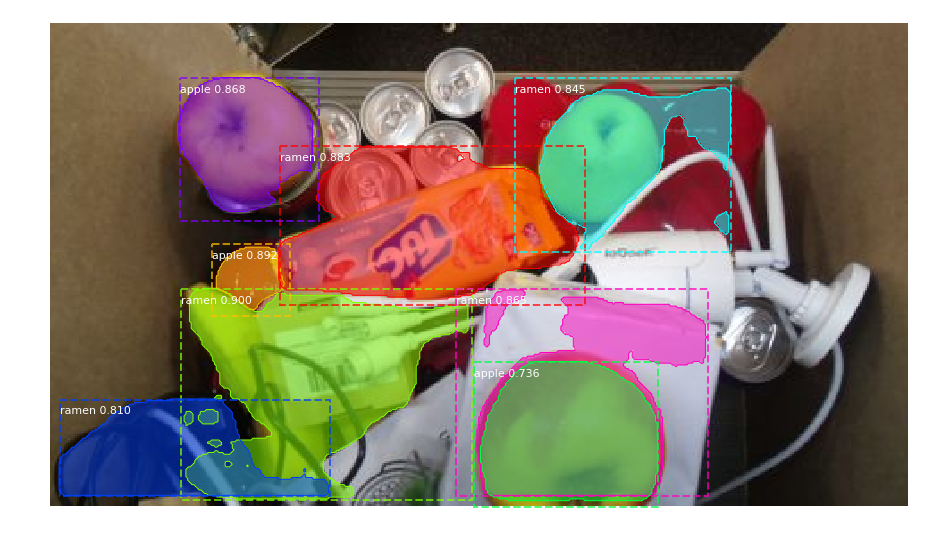

Object: ramen, Quantity: 5
 -- Quantity changed by 5
Object: apple, Quantity: 3
 -- Quantity changed by 3
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


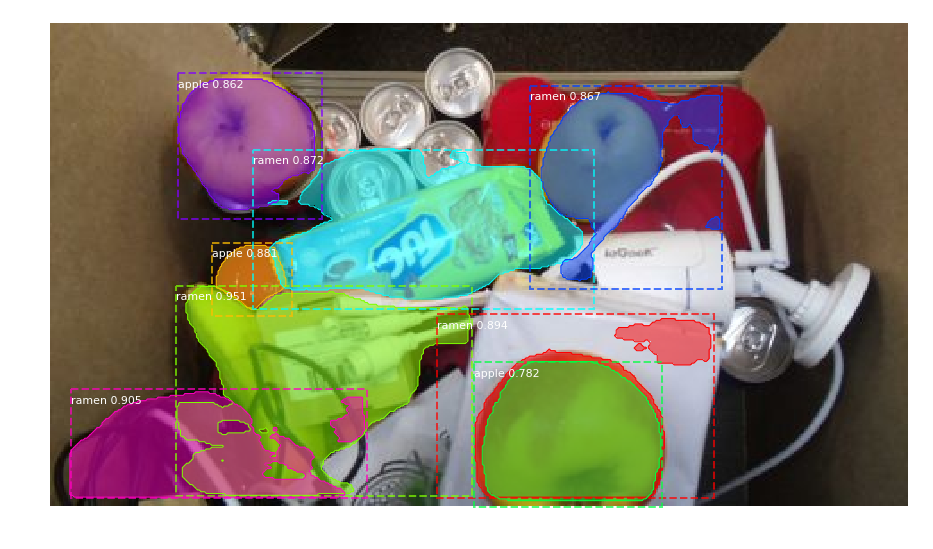

Object: ramen, Quantity: 5
Object: apple, Quantity: 3
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60


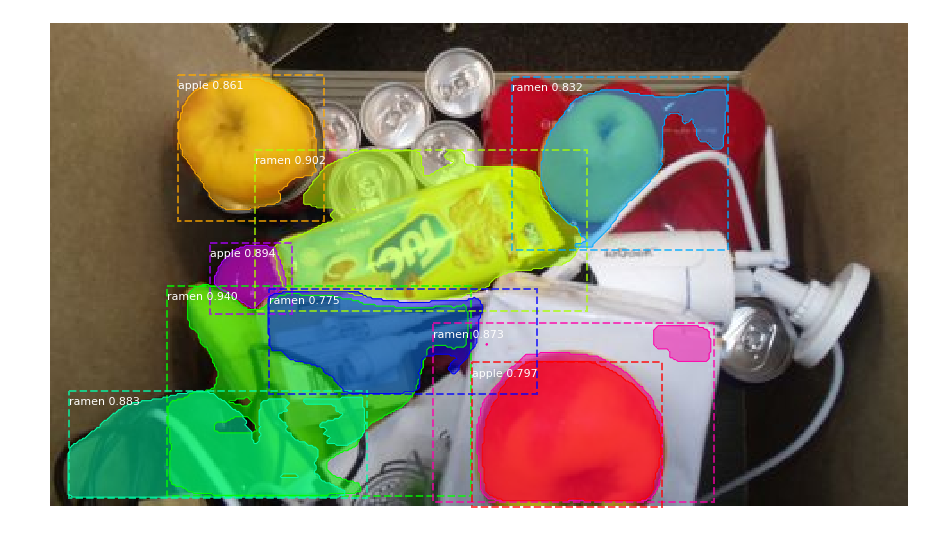

Object: ramen, Quantity: 6
 -- Quantity changed by 1
Object: apple, Quantity: 3
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90


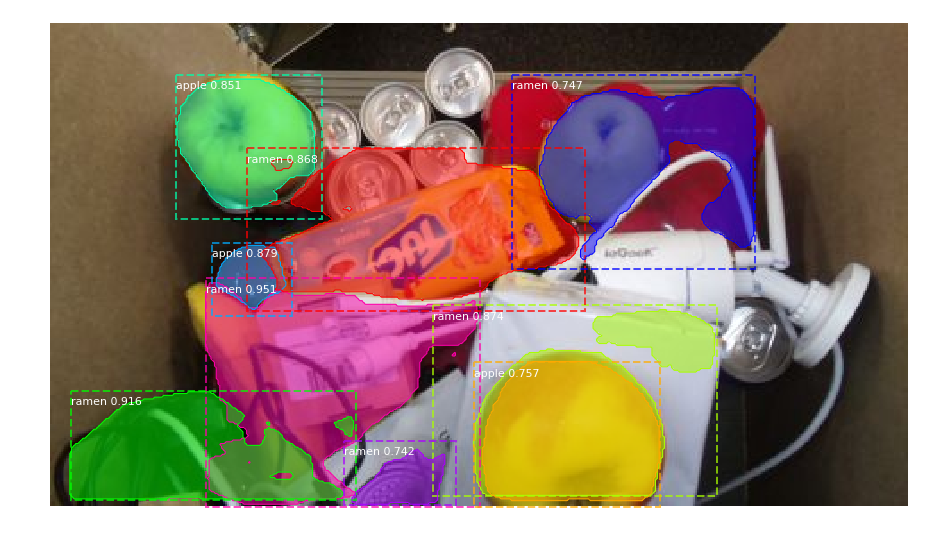

Object: ramen, Quantity: 6
Object: apple, Quantity: 3
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120


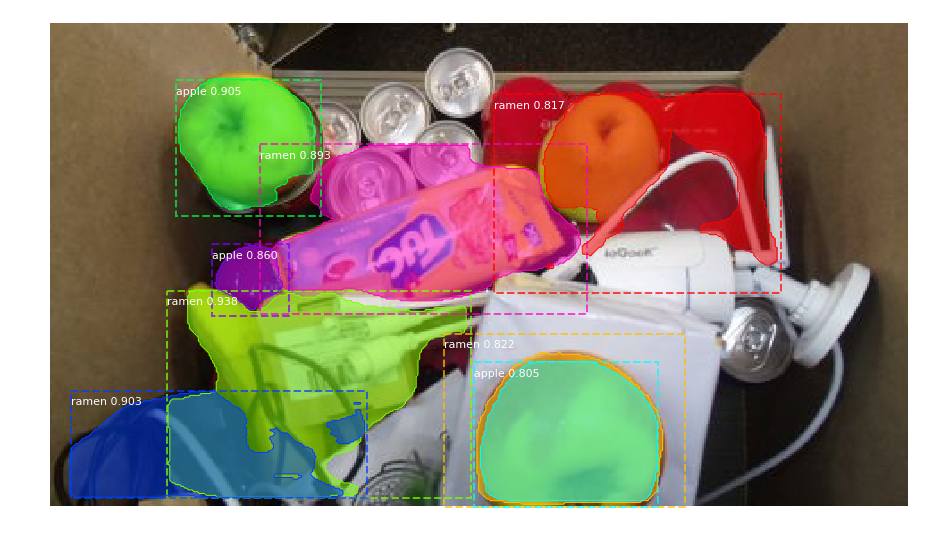

Object: ramen, Quantity: 5
 -- Quantity changed by -1
Object: apple, Quantity: 3
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150


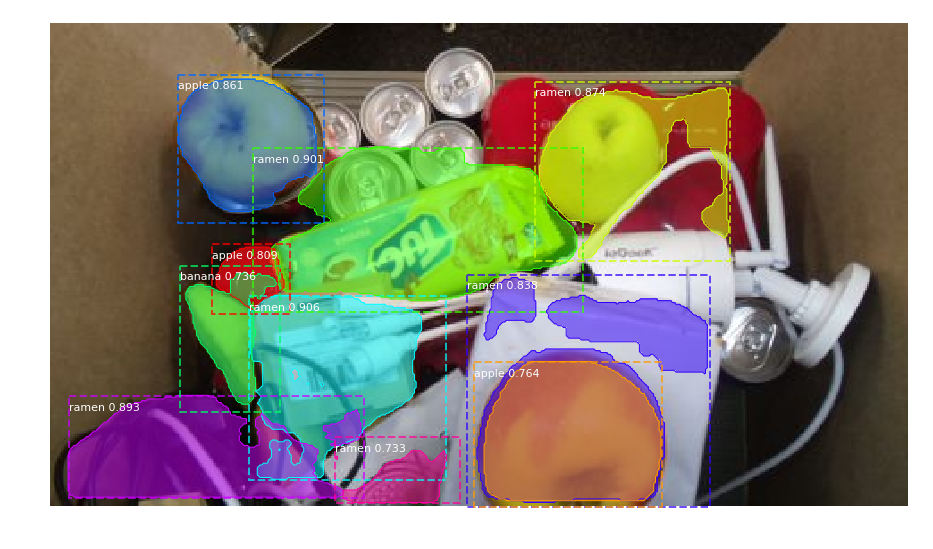

Object: ramen, Quantity: 6
 -- Quantity changed by 1
Object: apple, Quantity: 3
Object: banana, Quantity: 1
 -- Quantity changed by 1
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180


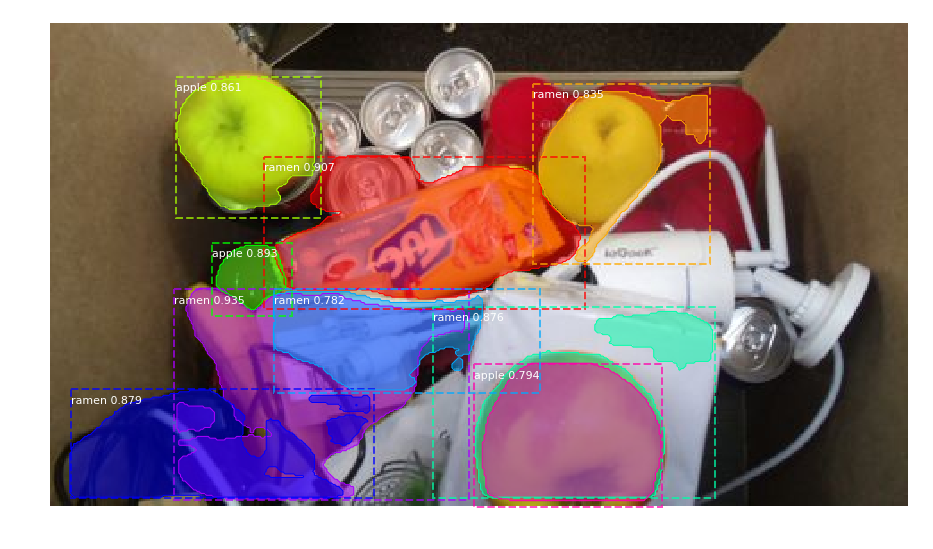

Object: ramen, Quantity: 6
Object: apple, Quantity: 3
 -- Object: banana, Quantity: 1 was removed
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210


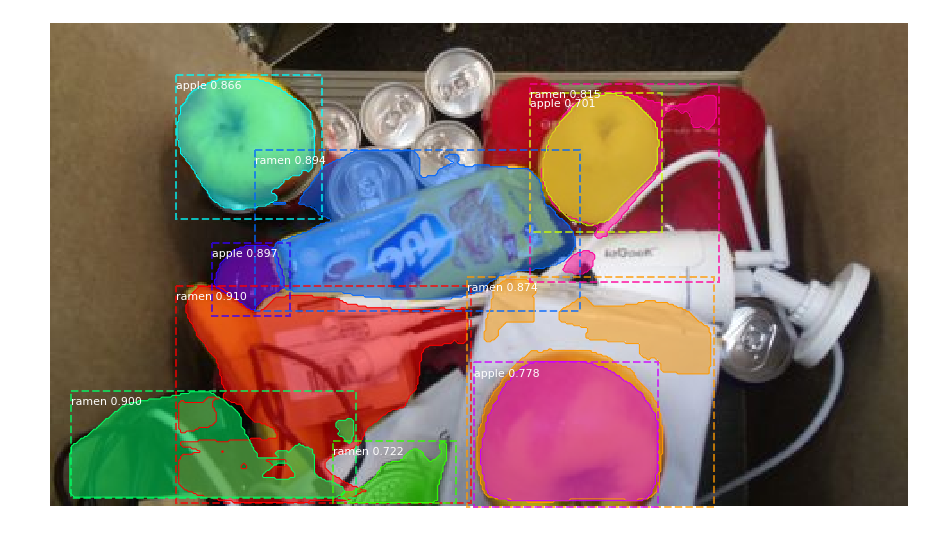

Object: ramen, Quantity: 6
Object: apple, Quantity: 4
 -- Quantity changed by 1
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240


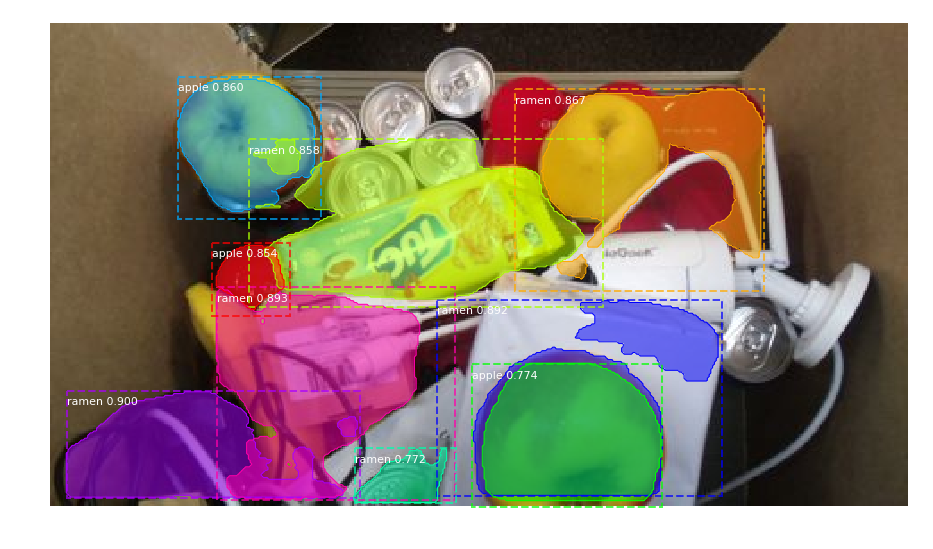

Object: ramen, Quantity: 6
Object: apple, Quantity: 3
 -- Quantity changed by -1
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270


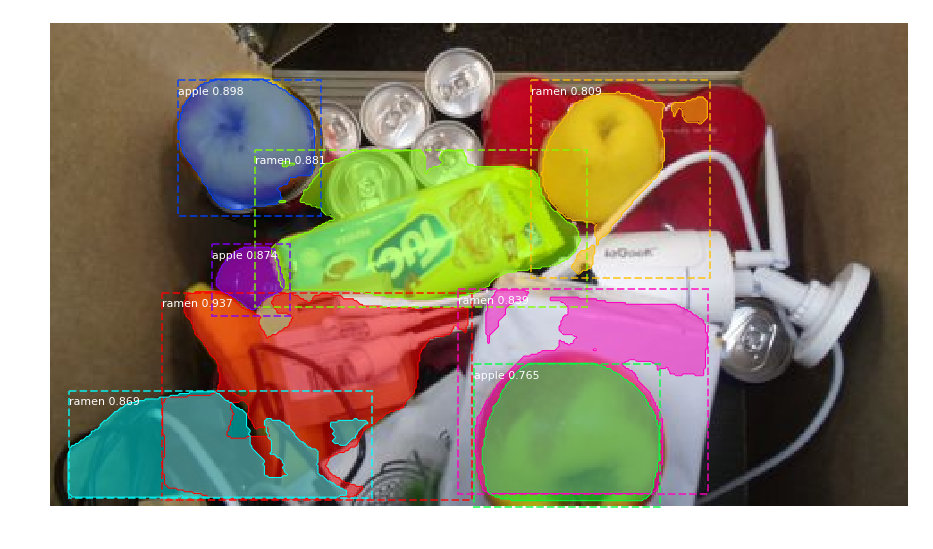

Object: ramen, Quantity: 5
 -- Quantity changed by -1
Object: apple, Quantity: 3
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300


In [0]:
import time
import cv2
import urllib.request as ur

import numpy as np
from google.colab.patches import cv2_imshow
#from IPython.display import clear_output

# run sudo ifconfig inside the pi to get the local network address "inet" but then need local hw 
# http://10.4.14.67/?action=stream
# https://stackoverflow.com/questions/54949143/opencv-unable-to-read-video-from-mjpeg-stream
# https://absorptive-heron-4484.dataplicity.io/?action=stream
stream=ur.urlopen(pi_address)
bytestring=b''
counter = 0
counter_list_prev = dict()
while True:
    bytestring+=stream.read(1024)
    a = bytestring.find(b'\xff\xd8')
    b = bytestring.find(b'\xff\xd9')
    if a !=- 1 and b != -1:
        jpg = bytestring[a:b+2]
        bytestring= bytestring[b+2:]
        i = cv2.imdecode(np.fromstring(jpg, dtype=np.uint8),cv2.IMREAD_COLOR)
        
        if(mode == "training" and counter % 10 == 0): # every second
            #save image to file
            img_label = training_label + str(counter) + ".jpg"
            cv2.imwrite(os.path.join('training_images/'+training_label, img_label), i)
            cv2_imshow(i)

        if(mode == "counting" and counter % 30 == 0): # with 10FPS this is one per three seconds
            #from matplotlib import pyplot as plt
            #plt.subplot(211),plt.imshow(i)
            #plt.xticks([]),plt.yticks([])
            #plt.pause(0.2);
            #cv2_imshow(i)
          
            image = cv2.cvtColor(i,cv2.COLOR_BGR2RGB)
            # Run detection
            results = model.detect([image], verbose=0)
            #results = model.detect([image], verbose=1)
            #print(results)

            # Visualize results
            r = results[0]
            visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                class_names, r['scores'])

            import collections
            class_ids = r['class_ids']
            counter_list = collections.Counter(class_ids)

            for key in counter_list:
                if not key in counter_list_prev:
                    counter_list_prev[key] = 0

                print("Object: {}, Quantity: {}".format(class_names[key], counter_list[key]))
                if counter_list_prev[key] != counter_list[key]:
                    print(" -- Quantity changed by {}".format(counter_list[key] - counter_list_prev[key]))

            for key in counter_list_prev:  
                if key in counter_list_prev and key not in counter_list:
                  print(" -- Object: {}, Quantity: {} was removed".format(class_names[key], counter_list_prev[key]))
              
            #save detection result for comparison
            counter_list_prev = counter_list

        counter += 1
        print(counter)
        
    #not meaningful inside Google colab
    #if cv2.waitKey(1) & 0xFF == ord('q'):
    #    break

    #time.sleep(0.1)

In [0]:
#download the training images
!zip -r /content/file.zip /content/training_images
from google.colab import files
files.download("/content/file.zip")

In [0]:
#rm -r training_images